In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path_logits = "/content/drive/My Drive/logits/"
path_logits_darts = path_logits + "logits_darts"
path_logits1 = path_logits + "logits1"
path_logits2 = path_logits + "logits2"
path_logits3 = path_logits + "logits3"

In [ ]:
import pickle
import os
import sys
import glob
import json
import numpy as np
import torch
import utils
import logging
import argparse
import pickle
import time
import torch.nn as nn
import torch.utils
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms


save = path_logits+'/test-{}-{}'.format("ENS", time.strftime("%Y%m%d-%H%M%S"))
utils.create_exp_dir(save, scripts_to_save=glob.glob('*.py'))

log_format = '%(asctime)s %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
    format=log_format, datefmt='%m/%d %I:%M:%S %p')
fh = logging.FileHandler(os.path.join(save, 'log.txt'))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)


class Cutout(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


def _data_transforms_cifar10(cutout,cutout_length):
  CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
  CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

  train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
  ])
  if cutout:
    train_transform.transforms.append(Cutout(cutout_length))

  valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])
  return train_transform, valid_transform




Experiment dir : /content/drive/My Drive/logits//test-ENS-20210206-163810


In [ ]:

_, test_transform = _data_transforms_cifar10(True,16)

test_data = dset.CIFAR10(root="../data", train=False, download=True, transform=test_transform)

test_queue = torch.utils.data.DataLoader(test_data, batch_size=96, shuffle=False, pin_memory=True, num_workers=2)



Extracting ../data/cifar-10-python.tar.gz to ../data


In [ ]:


targets_all = []
for step, (input, target) in enumerate(test_queue):
    input = Variable(input, volatile=True).cuda()
    targets = Variable(target, volatile=True).cuda(async=True)
    targets = targets.cpu().detach().numpy()
    targets_all.extend(targets)
    

#print(targets)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import copy

acc_darts_all = []
acc_1_all = []
acc_2_all = []
acc_3_all = []
acc_ensemble_all = []
for x in range(50):
  logits_darts = pickle.load( open( path_logits_darts + "/logits_"+str(x)+".p", "rb" ) )
  print(type(logits_darts))
  logits1 = pickle.load( open( path_logits1 + "/logits_"+str(x)+".p", "rb" ) )
  logits2 = pickle.load( open( path_logits2 + "/logits_"+str(x)+".p", "rb" ) )
  logits3 = pickle.load( open( path_logits3 + "/logits_"+str(x)+".p", "rb" ) )
  logits = copy.deepcopy(logits1)

  for i in range(len(logits)):
    for j in range(len(logits[i])):
      logits[i][j] = logits[i][j] + logits2[i][j] + logits3[i][j]
    
    predicted_darts_all = []
    for out in logits_darts:
      _, predicted = torch.max(out.data, 1)
      preds = predicted.cpu().detach().numpy()
      for pred in preds:
        predicted_darts_all.append(pred)


    predicted1_all = []
    for out in logits1:
      _, predicted = torch.max(out.data, 1)
      preds = predicted.cpu().detach().numpy()
      for pred in preds:
        predicted1_all.append(pred)

    predicted2_all = []
    for out in logits2:
      _, predicted = torch.max(out.data, 1)
      preds = predicted.cpu().detach().numpy()
      for pred in preds:
        predicted2_all.append(pred)

    predicted3_all = []
    for out in logits3:
      _, predicted = torch.max(out.data, 1)
      preds = predicted.cpu().detach().numpy()
      for pred in preds:
        predicted3_all.append(pred)

    predicted_all = []
    for out in logits:
      _, predicted = torch.max(out.data, 1)
      preds = predicted.cpu().detach().numpy()
      for pred in preds:
        predicted_all.append(pred)

  acc_darts_all.append(100*accuracy_score(predicted_darts_all,targets_all))
  acc_1_all.append(100*accuracy_score(predicted1_all,targets_all))
  acc_2_all.append(100*accuracy_score(predicted2_all,targets_all))
  acc_3_all.append(100*accuracy_score(predicted3_all,targets_all))
  acc_ensemble_all.append(100*accuracy_score(predicted_all,targets_all))
    #prec1, prec5 = accuracy(predicted_all, target_all)
  logging.info('test acc space 1 epoch %d %f',x,100* accuracy_score(predicted1_all,targets_all))
  logging.info('test acc space 2 epoch %d %f',x,100* accuracy_score(predicted2_all,targets_all))
  logging.info('test acc space 3 epoch %d %f',x,100* accuracy_score(predicted3_all,targets_all))
  logging.info('test ensemble acc epoch %d %f',x,100* accuracy_score(predicted_all,targets_all))
  logging.info('test darts acc epoch %d %f',x, 100*accuracy_score(predicted_darts_all,targets_all))


<class 'list'>
02/06 04:38:49 PM test acc space 1 epoch 0 47.740000
02/06 04:38:49 PM test acc space 2 epoch 0 45.160000
02/06 04:38:49 PM test acc space 3 epoch 0 46.450000
02/06 04:38:49 PM test ensemble acc epoch 0 53.650000
02/06 04:38:49 PM test darts acc epoch 0 46.640000
<class 'list'>
02/06 04:38:57 PM test acc space 1 epoch 1 58.470000
02/06 04:38:57 PM test acc space 2 epoch 1 52.190000
02/06 04:38:57 PM test acc space 3 epoch 1 55.350000
02/06 04:38:57 PM test ensemble acc epoch 1 63.940000
02/06 04:38:57 PM test darts acc epoch 1 56.140000
<class 'list'>
02/06 04:39:06 PM test acc space 1 epoch 2 63.220000
02/06 04:39:06 PM test acc space 2 epoch 2 59.960000
02/06 04:39:06 PM test acc space 3 epoch 2 60.360000
02/06 04:39:06 PM test ensemble acc epoch 2 68.010000
02/06 04:39:06 PM test darts acc epoch 2 58.210000
<class 'list'>
02/06 04:39:14 PM test acc space 1 epoch 3 68.240000
02/06 04:39:14 PM test acc space 2 epoch 3 65.060000
02/06 04:39:14 PM test acc space 3 epoch 3

In [ ]:
print(type(logits1))

<class 'list'>


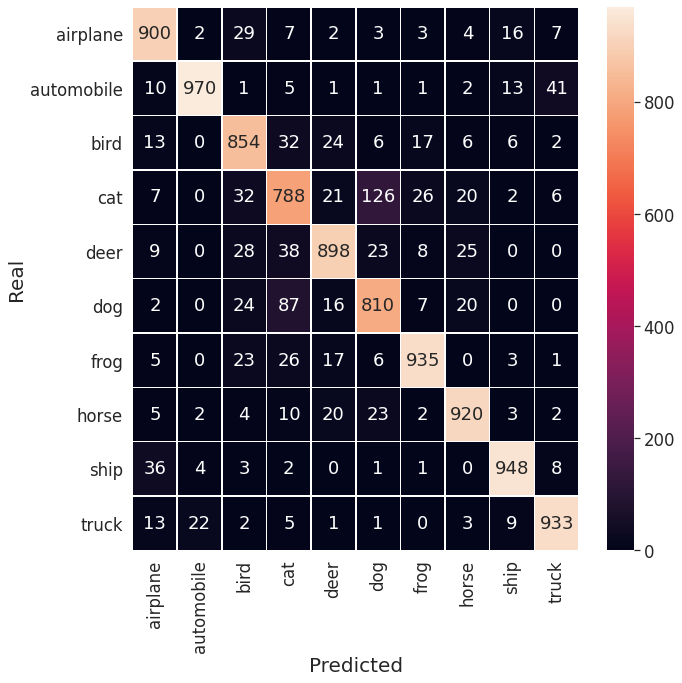

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


cm = confusion_matrix(predicted3_all,targets_all)

df_cm = pd.DataFrame(cm, columns= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'], index= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'])
plt.figure(figsize = (10,10))
sn.set(font_scale=1.5)
sn.heatmap(df_cm, annot=True, linewidths=.5, linecolor='white', fmt='g')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.show()


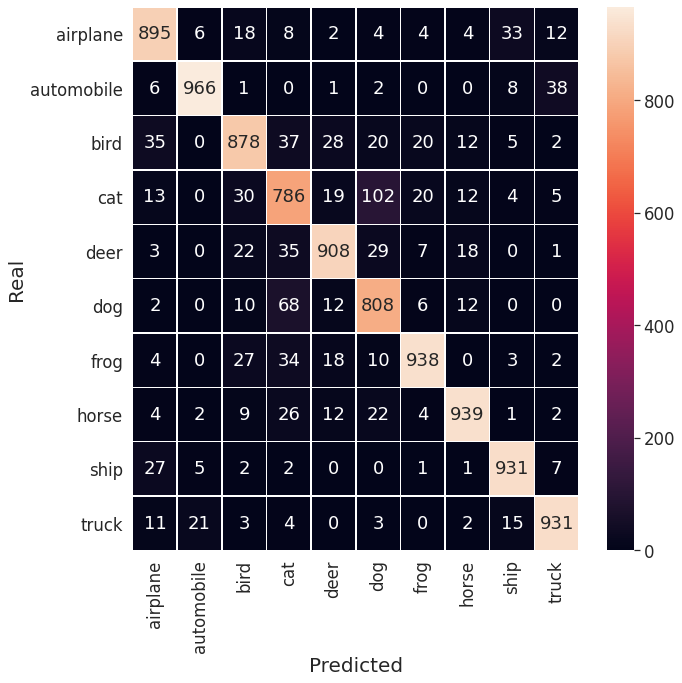

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


cm = confusion_matrix(predicted2_all,targets_all)

df_cm = pd.DataFrame(cm,columns= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'], index= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'])
plt.figure(figsize = (10,10))
sn.set(font_scale=1.5)
sn.heatmap(df_cm, annot=True, linewidths=.5, linecolor='white', fmt='g')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.show()


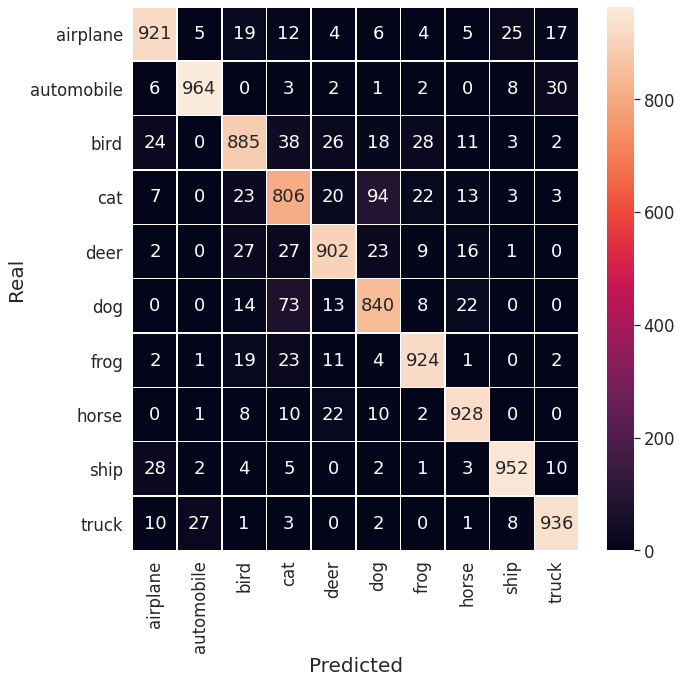

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


cm = confusion_matrix(predicted1_all,targets_all)

df_cm = pd.DataFrame(cm,columns= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'], index= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'])
plt.figure(figsize = (10,10))
sn.set(font_scale=1.5)
sn.heatmap(df_cm, annot=True, linewidths=.5, linecolor='white', fmt='g')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.show()


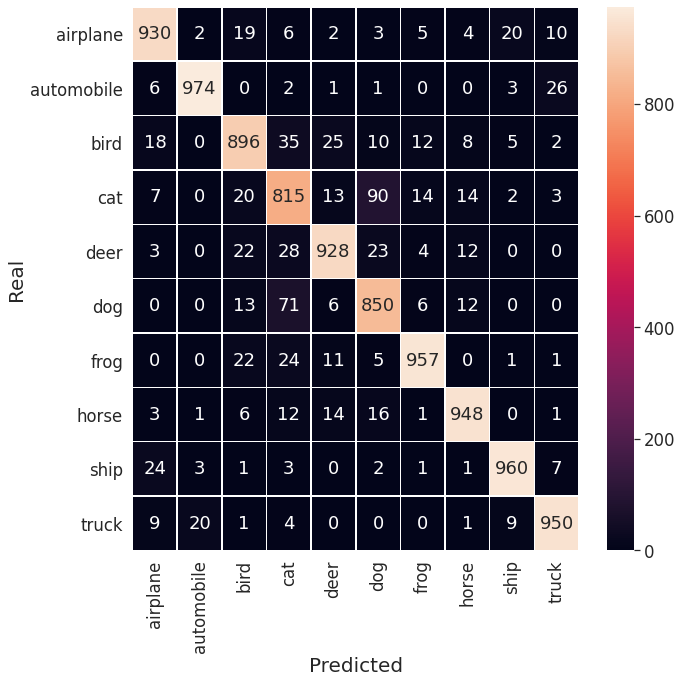

In [ ]:



cm = confusion_matrix(predicted_all,targets_all)

df_cm = pd.DataFrame(cm,columns= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'], index= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'])
plt.figure(figsize = (10,10))
sn.set(font_scale=1.5)
sn.heatmap(df_cm, annot=True, linewidths=.5, linecolor='white', fmt='g')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.show()

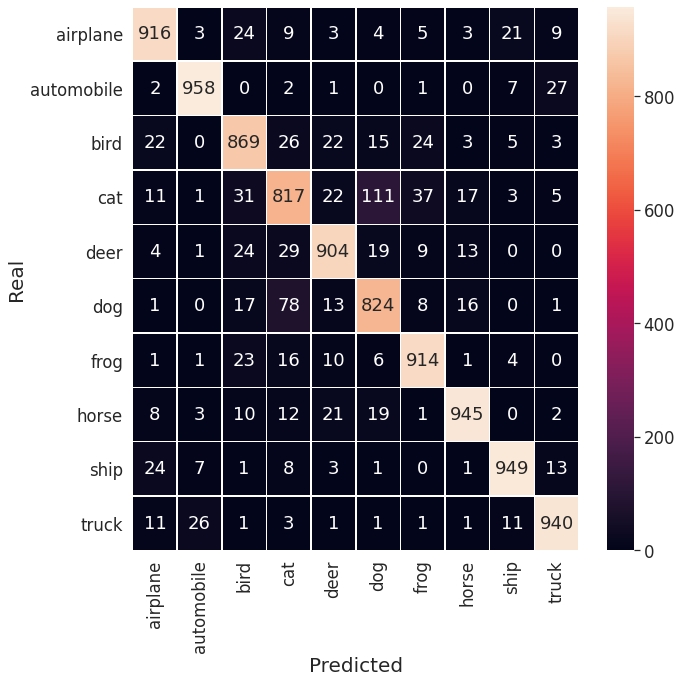

In [ ]:



cm = confusion_matrix(predicted_darts_all,targets_all)

df_cm = pd.DataFrame(cm,columns= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'], index= ['airplane','automobile',										
'bird',										
'cat',										
'deer',										
'dog',										
'frog',										
'horse',										
'ship',										
'truck'])
plt.figure(figsize = (10,10))
sn.set(font_scale=1.5)
sn.heatmap(df_cm, annot=True, linewidths=.5, linecolor='white', fmt='g')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Real', fontsize=20)
plt.show()

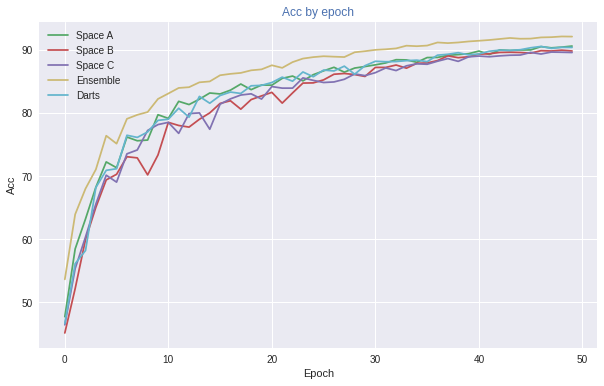

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

x = range(50)

# 100 valores no intervalo de 0 a 2.
x = range(50)
mpl.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Acc by epoch', color='C0')
ax.set_ylabel('Acc')
ax.set_xlabel('Epoch')
ax.plot(x, acc_1_all, 'C1', label='Space A')
ax.plot(x, acc_2_all, 'C2', label='Space B')
ax.plot(x, acc_3_all, 'C3', label='Space C')
ax.plot(x, acc_ensemble_all, 'C4', label='Ensemble')
ax.plot(x, acc_darts_all, 'C5', label='Darts')
ax.legend()